## **Гипотеза №2**
### $H_{0}$ : Между преступностью района и возрастом его зданий нет связи
### $H_{1}$ : Между преступностью района и возрастом его зданий есть связь
### Уровень статистической значимости = 0.05

## **Импорт библиотек**

In [1]:
import pandas as pd #библиотека для обработки и анализа данных в виде таблиц
import numpy as np #библиотека, добавляющая поддержку больших многомерных массивов и матриц, вместе с большой библиотекой высокоуровневых математических функций для операций с этими массивами

#scikit-learn — это библиотека, предназначенная для машинного обучения
from sklearn.linear_model import LinearRegression #линейная регрессия
from sklearn import preprocessing #предоставляет функции для преобразования данных в более подходящий вид для последующих оценок

import statsmodels.api as sm #позволяет исследовать данные, оценивать статистические модели и выполнять статистические тесты
import scipy.stats as stats
import seaborn as sns #эта библиотека предназначена для создания статистических графиков

from pyhive import hive

## **Подключение к базе данных и импорт данных**

In [11]:
#mart2 = pd.read_csv('mart2.csv')
conn = hive.Connection(host='localhost', port=10000, database='project')
cursor = conn.cursor()
query = "SELECT * FROM mart_2"
mart2 = pd.read_sql(query, conn)
conn.close()

/tmp/ipykernel_41877/2214197992.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  mart2 = pd.read_sql(query, conn)


In [4]:
mart2.head()

,mart_2.id,mart_2.price,mart_2.address,mart_2.district,mart_2.rooms,mart_2.current_floor,mart_2.max_floor,mart_2.build_year,mart_2.bath,mart_2.repair,mart_2.window_type,mart_2.total,mart_2.street,mart_2.kills,mart_2.harm,mart_2.theft,mart_2.robbery,mart_2.brigandage,mart_2.cameras
0,2,6000000.0,Москва ЗАО р-н Очаково-Матвеевское Аминьевское...,Очаково-Матвеевское,1.0,6.0,16.0,1976.0,1 раздельный,Косметический,Во двор,917.0,240.0,NaN,9.0,NaN,NaN,NaN,896
1,4,5450000.0,Москва ЮЗАО р-н Ясенево Голубинская ул. 7К5,Ясенево,NaN,1.0,9.0,1976.0,1 совмещенный,Евроремонт,На улицу и двор,798.0,NaN,1.0,NaN,NaN,21.0,NaN,733
2,5,5340000.0,Москва ЮЗАО р-н Коньково Профсоюзная ул. 73,Коньково,1.0,5.0,15.0,1973.0,1 раздельный,Без ремонта,,923.0,225.0,1.0,4.0,457.0,12.0,4.0,883
3,6,6230000.0,Москва ВАО р-н Богородское Ивантеевская ул. 9А,Богородское,NaN,2.0,5.0,1955.0,1 совмещенный,Дизайнерский,,876.0,211.0,3.0,NaN,429.0,15.0,NaN,1353
4,7,6960000.0,Москва ВАО р-н Богородское Ивантеевская ул. 9А,Богородское,NaN,2.0,5.0,1955.0,1 совмещенный,Дизайнерский,,876.0,211.0,3.0,NaN,429.0,15.0,NaN,1353


## **Очищение и преобразование данных**

**Выброс** — это наблюдение, которое лежит аномально далеко от других значений в наборе данных. Выбросы могут быть проблематичными, поскольку они могут повлиять на результаты анализа.
Для удаления выбросов будем использовать межквартильный диапазон.

**Межквартильный размах (IQR)** — это разница между 75-м процентилем (Q3) и 25-м процентилем (Q1) в наборе данных. Он измеряет разброс средних 50% значений.
Можно определить наблюдение как выброс, если оно в 1,5 раза превышает межквартильный размах, превышающий третий квартиль (Q3), или в 1,5 раза превышает межквартильный размах, меньше первого квартиля (Q1).
Выбросы = наблюдения > Q3 + 1,5*IQR или Q1 – 1,5*IQR

In [5]:
mart2.dropna(subset=['mart_2.price'], inplace=True)
q3, q1 = np.percentile(mart2['mart_2.price'], [75, 25]) #получаем 75-й и 25-й процентили колонки price
IQR = q3 - q1 #рассчитываем межквартильный размах
upper_bound = q3 + 1.5 * IQR #получаем высшую границу
lower_bound = q1 - 1.5 * IQR #получаем низшую границу

mart2 = mart2[(mart2['mart_2.price'] < upper_bound) & (mart2['mart_2.price'] > lower_bound)] #выбираем только те записи, у которых цена находится в пределах границ

In [6]:
#линейная регрессия не может работать со строками, их нужно заменить на числовые значения
le = preprocessing.LabelEncoder() #(Кодирование меток) - метод, который присваивает каждому уникальному значению категориального признака уникальное целочисленное значение
le.fit(mart2['mart_2.district'])
mart2['district_num'] = le.transform(mart2['mart_2.district']) #создание нового столбца с замененными строковыми данными на целочисленные

Выбираем нужные столбцы и удаляем записи с пропущенными значениями

In [7]:
model_data = mart2.loc[:, ['mart_2.price', 'district_num', 'mart_2.rooms', 'mart_2.current_floor', 'mart_2.build_year', 'mart_2.total']].dropna()

## **Регрессионный анализ**

Проверяем данные на мультиколлинеарность, так как для линейной регрессии атрибуты не должны иметь связи

<Axes: >

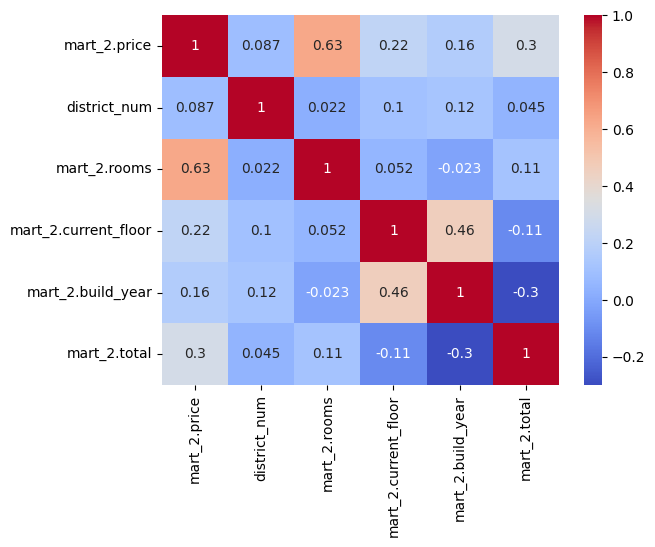

In [8]:
sns.heatmap(model_data.corr(), annot=True, cmap='coolwarm')

In [9]:
X = model_data.loc[:, ['mart_2.price', 'district_num', 'mart_2.rooms', 'mart_2.current_floor', 'mart_2.build_year']] #В качестве X выбираем независимые переменные
Y = model_data['mart_2.total'] #В качестве Y выбираем зависимую переменную, в нашем случае, цену

Проводим регрессионный анализ

In [10]:
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           mart_2.total   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     1265.
Date:                Thu, 20 Apr 2023   Prob (F-statistic):               0.00
Time:                        12:53:56   Log-Likelihood:            -1.4726e+05
No. Observations:               19402   AIC:                         2.945e+05
Df Residuals:                   19396   BIC:                         2.946e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1.624e+04    289.625     56.082      0.000    1.57e+04    1.68e+04
mart_2.price          2.409e-05   4.04e-07     59.564      0.000    2.33e-05    2.49e-05
district_num             0.9113      0.101      8.990      0.000       0.713       1.110
mart_2.rooms          -129.6898      5.169    -25.088      0.000    -139.822    -119.557
mart_2.current_floor    -3.2515      0.589     -5.524      0.000      -4.405      -2.098
mart_2.build_year       -7.6997      0.147    -52.494      0.000      -7.987      -7.412
==============================================================================
Omnibus:                     7030.644   Durbin-Watson:                   1.894
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            30058.487
Skew:                           1.752   Prob(JB):                         0.00
Kurtosis:                       7.990   Cond. No.                     1.97e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.97e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## **Выводы**
Коэффициент атрибута build_year равняется $-7.6997$ и имеет p-value < уровня статистической значимости (0.05), значит мы опровергаем нулевую гипотезу, следовательно между преступностью района и возрастом его зданий есть связь. Более того, исходя из коэффициента регрессии можно сделать вывод о том, что в районах с более высоким уровнем преступности более старые дома